# Working With NHDPlus High-Resolution Data

This code provides an example on how to prepare the NHDPlus High-Resolution dataset for use in the Meander Characterization package. The information can be downloaded from the following website: https://www.usgs.gov/core-science-systems/ngp/national-hydrography/nhdplus-high-resolution.

In this workflow, we will use the HUC 0602 NHDPlus High-Resolution that is saved in the `NHDPlus_HR/raw_data/` folder, and the resulting files will be saved in the `./NHDPlus_HR/processed_data/NHDPlus_H_0602_HU4_GDB/` folder. 

## Extracting NHD Information
### Importing Packages

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl

In [77]:
# Importing Packages
import geopandas
import fiona
import os
import time
import copy
import numpy as np
import pyproj
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from IPython.display import Image, display, HTML
from joblib import Parallel, delayed
import plotly.io as pio
import ipywidgets as widgets
from IPython.display import display
from scipy.spatial import Delaunay
from scipy.spatial.distance import euclidean
import warnings

# Importing pyMeander Packages
from WigglyRivers import RiverDatasets as Rivers
from WigglyRivers import RiverFunctions as RF
from WigglyRivers import ExtractNHDPlusHRData as NHD
from WigglyRivers.utilities import utilities as utl
from WigglyRivers.utilities import filesManagement as FM
from WigglyRivers import Logger
from WigglyRivers import WaveletTreeFunctions as WTFunc
from WigglyRivers import graphs

In [78]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
# Start Logger
logger = Logger(console=False)

In [31]:
# Parameters
# huc_id = '0602'
# huc_id = '0104'
# huc_id = '0601'
huc_id = '0513'
path_nhd = f'./NHDPlus_HR/raw_data/NHDPlus_H_{huc_id}_HU4_GDB/'
path_output = f'./NHDPlus_HR/processed_data/NHDPlus_H_{huc_id}_HU4_GDB/'
path_river_routing = f'{path_output}/river_routing/'
path_meander_info = f'{path_output}/meanders/'
file_name = f'NHDPlus_H_{huc_id}_HU4_GDB.gdb'
projection = 'esri:102003'

### Extract NHDPlus HR Data

To do the preprocessing of information we use the following function

In [5]:
# Create Logger
# Create NHD object
time_1 = time.time()
nhd = NHD(path_output=path_output, logger=logger, save_format='feather')
nhd.get_data_from_nhd_gbd(f'{path_nhd}{file_name}', projection=projection)
utl.toc(time_1)

2024-01-31 06:25:19,187[INFO] info: Start Logger in ExtractNHDPlusHRData
2024-01-31 06:25:19,187[INFO] info: Start: Extracting data from './NHDPlus_HR/raw_data/NHDPlus_H_0513_HU4_GDB/NHDPlus_H_0513_HU4_GDB.gdb'


2024-01-31 06:25:19,188[INFO] info:  Start: Load Shapefile
2024-01-31 06:25:28,006[INFO] info:  Done: Load Shapefile
2024-01-31 06:25:28,006[INFO] info:  Setting shapefile projection to esri:102003
2024-01-31 06:25:28,414[INFO] info:  Start: Extraction of coordinates
2024-01-31 06:25:32,979[INFO] info:  Done: Extraction of coordinates
2024-01-31 06:25:44,007[INFO] info:  Start: Merging Tables
2024-01-31 06:25:44,008[INFO] info:   Merging NHDPlusFlowlineVAA
2024-01-31 06:26:00,443[INFO] info:   Merging NHDPlusEROMMA
2024-01-31 06:26:09,632[INFO] info:  Done: Merging Tables
2024-01-31 06:26:09,662[INFO] info:  Saving ./NHDPlus_HR/processed_data/NHDPlus_H_0513_HU4_GDB//tables//file_tables_raw.feather
2024-01-31 06:26:09,761[WARNING] warning:   WARNING: The coordinates are always saved as 'hdf5'
2024-01-31 06:26:09,762[INFO] info:  Saving ./NHDPlus_HR/processed_data/NHDPlus_H_0513_HU4_GDB//coordinates//file_coords_raw.hdf5
2024-01-31 06:26:17,402[WARNING] warning:   WARNING: The coordinate

====	1.0979 minutes	 ====


### Extracting Complete Reach Data

The NHD network is composed of reach information that is separated by COMID values, in this case the COMID is called `NHDPlusID`. The function above separated the coordinates and the table with all the data related to each reach.

As our objective is to capture meanders we need complete reach information, that is, we need to extract coordinates from rivers that can spam the union of several reach values. To do that we will use the methods within the `Rivers` class that uses the preprocessed data extracted above.

To do that we need to follow the steps below:

1. **Start River Object**: This process is performed within the `Rivers` class. 


In [5]:
# Directories of the information
path_tables = f'{path_output}/tables/'
path_coords = f'{path_output}/coordinates/'

# Create Rivers object
rivers = Rivers(logger=logger)
# Add  files
rivers.add_files(path_data=path_tables, huc04=huc_id, path_coords=path_coords,
                comid_id='nhdplusid', load_coords=True)

2024-01-31 08:02:31,003[INFO] info: Start Logger in RiverDatasets


2024-01-31 08:02:31,344[INFO] info: Starting logger CompleteReachExtraction
2024-01-31 08:02:31,445[INFO] info: Loading coordinates from ./NHDPlus_HR/processed_data/NHDPlus_H_0513_HU4_GDB//coordinates/file_coords_p_102003_raw.hdf5


2. **Map the reach network**: In this step we map all the reach information going upstream from the outlet of the catchment to the headwaters, mapping first the longest streams to the shortest ones. This is done by the `map_network(method='upstream')` method.
   
   The mapping will extract a vector with a sequence of the connecting COMIDs for each complete reach. The method will save two files, first the `comid_network.hdf5` has the vectors with the connecting COMIDS and the headwater as the key. The second file is the `linking_network.feather` which is a table with information related to the links.

In [7]:
# Map the reach network
logger.info('Mapping Network')
rivers.map_network(method='upstream', huc=4, path_out=path_river_routing)

2024-01-31 06:27:26,816[INFO] info: Mapping Network
2024-01-31 06:27:26,816[INFO] info: Mapping the complete network
2024-01-31 06:27:26,817[INFO] info: Mapping through upstream method


/Users/dgd042/Documents/work/myRepos/inDevelopment/WigglyRivers/WigglyRivers/rivers/ReachExtraction.py:317: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1003725.5538079  1004420.81341557 1002750.96962757 ...  785484.03356287
  783739.77776752  783824.83147533]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.linking_network.loc[c_comid, 'xm_m'] = comid_table.loc[
/Users/dgd042/Documents/work/myRepos/inDevelopment/WigglyRivers/WigglyRivers/rivers/ReachExtraction.py:319: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ -58502.44863311  -56428.91772805  -54373.55560827 ... -112268.11913902
  -36623.43572256  -33727.76522007]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.linking_network.loc[c_comid, 'ym_m'] = comid_table.loc[
/Users/dgd042/Documents/work

Ext. huc 0513:   0%|          | 0/314 [00:00<?, ?it/s]

 Ext. Extra Nodes:   0%|          | 0/80816 [00:00<?, ?it/s]

3. **Get Reach From Network**: Now that we have already mapped the comid values through the network we need to extract the coordinates from that mapping. This process can take a long time depending on how large the network is and how many reaches the user is extracting. In this example we are only going to extract five complete reaches.

    This method creates the `river_network_huc_{huc_number}.hdf5` file that contains the coordinates for the complete reach an uses the headwaters as key.


In [6]:
logger.info('Load Mapping')
linking_network_file = f'{path_river_routing}/linking_network.feather'
comid_network_file = f'{path_river_routing}/comid_network.hdf5'
rivers.load_linking_network(linking_network_file)
huc_list = rivers.load_huc_list_in_comid_network(comid_network_file)
huc = huc_list[0]
headwaters = rivers.load_extracted_in_comid_network(
    comid_network_file, huc=huc)
# headwaters_to_extract = headwaters[huc][:2000]
headwaters_to_extract = headwaters[huc]

2024-01-31 08:02:45,178[INFO] info: Load Mapping


In [7]:
# Add Mapping Reaches
logger.info(f'Extracting {len(headwaters_to_extract)} Coordinates')
rivers.get_reaches_from_network(
    huc=huc,
    headwaters_comid=headwaters_to_extract,
    linking_network_file=linking_network_file,
    min_distance=100.0, path_out=path_river_routing)

2024-01-31 08:02:53,005[INFO] info: Extracting 30919 Coordinates


/Users/dgd042/Documents/work/myRepos/inDevelopment/WigglyRivers/WigglyRivers/rivers/RiverFunctions.py:1257: RuntimeWarning: divide by zero encountered in log
  cond_1 = (np.log(da) < 1.6)
/Users/dgd042/Documents/work/myRepos/inDevelopment/WigglyRivers/WigglyRivers/rivers/RiverFunctions.py:1258: RuntimeWarning: divide by zero encountered in log
  cond_2 = (np.log(da) >= 1.6) & (np.log(da) < 5.820)
/Users/dgd042/Documents/work/myRepos/inDevelopment/WigglyRivers/WigglyRivers/rivers/RiverFunctions.py:1259: RuntimeWarning: divide by zero encountered in log
  cond_3 = (np.log(da) >= 5.820)
/Users/dgd042/Documents/work/myRepos/inDevelopment/WigglyRivers/WigglyRivers/rivers/RiverFunctions.py:1257: RuntimeWarning: divide by zero encountered in log
  cond_1 = (np.log(da) < 1.6)
/Users/dgd042/Documents/work/myRepos/inDevelopment/WigglyRivers/WigglyRivers/rivers/RiverFunctions.py:1258: RuntimeWarning: divide by zero encountered in log
  cond_2 = (np.log(da) >= 1.6) & (np.log(da) < 5.820)
/Users/dg

In [8]:
rivers.reach_generator.linking_network

,startflag,within_waterbody,extracted_comid,linking_comid,huc12,huc10,huc08,huc06,huc04,huc02,huc_n,n_tributaries,xm_m,ym_m,xup_m,yup_m,xdown_m,ydown_m
nhdplusid,,,,,,,,,,,,,,,,,,
24001400069170,1.0,0.0,1,24001400037980,05130104001122,0513010400,05130104,051301,0513,05,4,2,1.003726e+06,-58502.448633,1.004135e+06,-58495.070121,1.003222e+06,-58498.816443
24001400069171,1.0,0.0,1,24001400007164,05130104002341,0513010400,05130104,051301,0513,05,4,1,1.004421e+06,-56428.917728,1.004805e+06,-56243.485626,1.004092e+06,-56590.347156
24001400069172,1.0,0.0,1,24001400007167,05130104002244,0513010400,05130104,051301,0513,05,4,1,1.002751e+06,-54373.555608,1.002267e+06,-53880.514018,1.003559e+06,-54571.285899
24001400069173,1.0,0.0,1,24001400017304,05130104002262,0513010400,05130104,051301,0513,05,4,1,1.003971e+06,-54748.264577,1.004343e+06,-54849.397142,1.003713e+06,-54524.392276
24001400069174,0.0,0.0,1,24001400027617,05130104002022,0513010400,05130104,051301,0513,05,4,1,1.002957e+06,-46950.783479,1.002962e+06,-46970.097883,1.002954e+06,-46935.947016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24001400074257,1.0,0.0,1,24001400063884,05130204001546,0513020400,05130204,051302,0513,05,4,2,7.859615e+05,-117696.570475,7.853893e+05,-117324.927822,7.861397e+05,-117772.105943
24001400074258,1.0,0.0,1,24001400043090,05130204000534,0513020400,05130204,051302,0513,05,4,2,7.870391e+05,-118680.596174,7.866009e+05,-119065.059440,7.870989e+05,-117959.214289
24001400074259,1.0,0.0,1,24001400032545,05130204001462,0513020400,05130204,051302,0513,05,4,2,7.854840e+05,-112268.119139,7.849950e+05,-112562.713570,7.859186e+05,-112138.075484


## Explore Network

With the `river_network_huc_{huc_number}.hdf5` file we can start exploring the network. We start by loading the file and plotting the network.

In [10]:
# Load network into River
huc_list = rivers.load_huc_list_in_comid_network(comid_network_file)
huc = huc_list[0]
river_network_file = f'{path_river_routing}/river_network_huc_{huc}.hdf5'
rivers.load_river_network(river_network_file)
starting_comids = rivers.id_values


/Users/dgd042/anaconda3/envs/geopandas_env10/lib/python3.10/site-packages/ipympl/backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


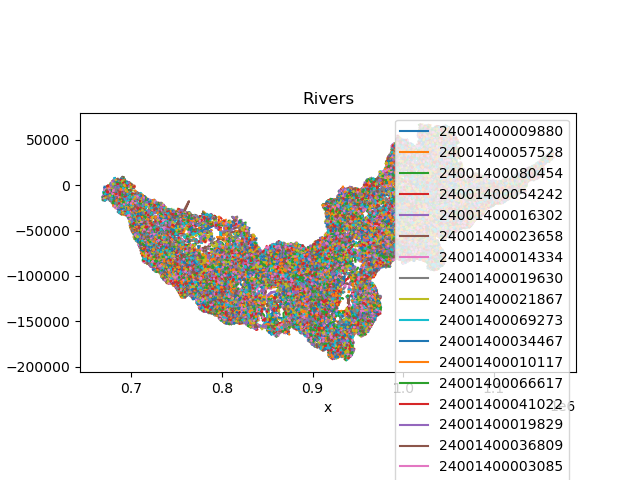

In [11]:
# Plot with matplotlib
fig = rivers.plot_rivers(engine='matplotlib')

The user can also create an interactive plot using the `plotly` engine.

In [ ]:
# Plot with plotly
fig = rivers.plot_rivers(engine='plotly')
fig.show()

An important part of plotting been able to plot with plotly is that we can use [MAPBOX](https://www.mapbox.com/), this is an app that allows the plotting with satellite images on the background. To use MAPBOX you would need to first create an account and get a token. Then you can pass `mapbox_token` as an additional parameter of the `plot_rivers` method.

Keep in mind that MAPBOX uses `EPSG:4326` to plot the information, usually the coordinates passed into rivers should be in projected coordiantes because we perform distance operations on them. Thus, you should also give the `current_crs` as another parameter and the method will project the coordiantes to `EPSG:4326` before plotting.

In this example I created a file called `.env` in the same folder as this notebook and added the following line: `MAPBOX_TOKEN=your_token_here`. Then I used the `load_dotenv` method from the `dotenv` package to load the token into the environment variables. Finally, I used the `os` package to get the token from the environment variables.

In [ ]:
# Load .env file
import dotenv
satellite_figure = True
dotenv.load_dotenv()
MAPBOX_TOKEN = os.environ['MAPBOX_TOKEN']
# Plot with plotly the first 10 rivers
comids = starting_comids[:100]
fig = rivers.plot_rivers(engine='plotly', mapbox_token=MAPBOX_TOKEN,
                         comids=comids, current_crs='esri:102003', zoom=7)
fig.show()

## Meander Characterization App

Now that we have the informaiton form each reach we characterize meanders on the river networks. To do that we use the `river.interactive_meander_characterization_plot()`. 

Keep in mind that if you want to select a meanders that are on each side of the river you would need to hide the already selected meanders clicking on them on the legend.

In [20]:
# Directories of the information
path_tables = f'{path_output}/tables/'
path_coords = f'{path_output}/coordinates/'

# Create Rivers object
rivers = Rivers(logger=logger)
# Add  files
rivers.add_files(path_data=path_tables, huc04=huc_id, path_coords=path_coords,
                comid_id='nhdplusid', load_coords=True)
# Load Linking Files
linking_network_file = f'{path_river_routing}/linking_network.feather'
comid_network_file = f'{path_river_routing}/comid_network.hdf5'
rivers.load_linking_network(linking_network_file)

# Load HUC files extracted
huc_list = rivers.load_huc_list_in_comid_network(comid_network_file)
huc = huc_list[0]
headwaters = rivers.load_extracted_in_comid_network(
    comid_network_file, huc=huc)
headwaters = headwaters[huc]

# Load headwaters
river_network_file = f'{path_river_routing}/river_network_huc_{huc}.hdf5'
# headwaters = rivers.load_river_network_ids(river_network_file)

# kwargs resample
kwargs_resample = {hw: {'smooth': 1e2} for hw in headwaters[:10]}

rivers.load_river_network(river_network_file, headwaters_comid=headwaters[:10],
                          kwargs_resample=kwargs_resample)
id_rivers = rivers.id_values
print(id_rivers)

2024-01-15 09:43:47,835[INFO] info: Start Logger in RiverDatasets
2024-01-15 09:43:48,300[INFO] info: Starting logger CompleteReachExtraction
2024-01-15 09:43:48,397[INFO] info: Loading coordinates from ./NHDPlus_HR/processed_data/NHDPlus_H_0602_HU4_GDB//coordinates/file_coords_p_102003_raw.hdf5
2024-01-15 09:43:57,948[INFO] info: Resample calculated with `River.calculate_spline()`
2024-01-15 09:43:58,070[INFO] info: Resample calculated with `River.calculate_spline()`
2024-01-15 09:43:58,122[INFO] info: Resample calculated with `River.calculate_spline()`
2024-01-15 09:43:58,234[INFO] info: Resample calculated with `River.calculate_spline()`
2024-01-15 09:43:58,556[INFO] info: Resample calculated with `River.calculate_spline()`
2024-01-15 09:43:58,638[INFO] info: Resample calculated with `River.calculate_spline()`
2024-01-15 09:43:58,788[INFO] info: Resample calculated with `River.calculate_spline()`
2024-01-15 09:43:58,890[INFO] info: Resample calculated with `River.calculate_spline()`

['25000300004620', '25000300015040', '25000300008327', '25000300034708', '25000300028648', '25000300035305', '25000300009214', '25000300007091', '25000300029063', '25000300025666']


In [21]:
# Do interactive plot
id_river = id_rivers[0]
rivers[id_river].interactive_meander_characterization_plot()

FigureWidget({
    'data': [{'line': {'color': 'blue', 'width': 2},
              'mode': 'lines',
              'name': 'River',
              'type': 'scatter',
              'uid': '0b4b2ebf-30e1-4f24-80a5-99656ca04e5e',
              'x': array([1103000.39724166, 1103002.55583581, 1103004.70443473, ...,
                           987181.26047446,  987179.91611887,  987178.5721644 ]),
              'y': array([-224746.84110729, -224747.18415736, -224747.5324061 , ...,
                          -176790.84861334, -176789.66288354, -176788.46865802])}],
    'layout': {'autosize': True,
               'height': 500,
               'hovermode': 'closest',
               'margin': {'b': 0, 'l': 0, 'r': 0, 't': 0},
               'plot_bgcolor': 'white',
               'showlegend': True,
               'template': '...',
               'width': 800,
               'xaxis': {'linecolor': 'black',
                         'mirror': True,
                         'showgrid': False,
         

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U14'), dtype('<U14')) -> None

Similar to the plot presented above, we can also select meanders with a satellite image on the back. However, there is known issue with `plotly<=5.15` where plotting mapbox with the interactive widget will prompt the following error message:

```python
ValueError:
Invalid property path 'mapbox._derived' for layout
```

There is a temporary fix to this issue given in the following [GitHub issue webpage](https://github.com/plotly/plotly.py/issues/2570) that requires to run the code block below and restart the kernel.

In [21]:
# To fix the widget error on plotly with mapbox uncomment the following line
# utl.fix_widget_error()

After solving this issue we can use the `interactive_meander_characterization_plot` method by giving the `mapbox_token` and `current_crs` parameters. The plot will work exactly the same as the interactive plot above where you can select the starting and ending points of a meander and the interactive plot will create a new meander show it in red in the plot.

In [18]:
# Do interactive plot
import dotenv
id_river = id_rivers[2]
satellite_figure = True
dotenv.load_dotenv()
MAPBOX_TOKEN = os.environ['MAPBOX_TOKEN']
rivers[id_river].interactive_meander_characterization_plot(
    mapbox_token=MAPBOX_TOKEN, current_crs='esri:102003', zoom=7)


FigureWidget({
    'data': [{'lat': array([35.62205853, 35.62168827, 35.62131352, ..., 35.00307537, 35.00324897,
                            35.00341401]),
              'line': {'color': 'blue', 'width': 2},
              'lon': array([-84.7799732 , -84.77957384, -84.77921051, ..., -85.61845471,
                            -85.61892838, -85.61939792]),
              'mode': 'lines',
              'name': 'River',
              'type': 'scattermapbox',
              'uid': 'd50548c5-3474-4924-90c1-daf3bb146326'}],
    'layout': {'autosize': True,
               'height': 500,
               'hovermode': 'closest',
               'mapbox': {'accesstoken': ('pk.eyJ1IjoiZGdkMDQyIiwiYSI6ImN' ... '2ZzcifQ.Y0LQAws3OWtzte09c-zv0g'),
                          'bearing': 0,
                          'center': {'lat': 35.23997044734469, 'lon': -85.17536328719937},
                          'pitch': 0,
                          'style': 'satellite',
                          'zoom': 7},
         

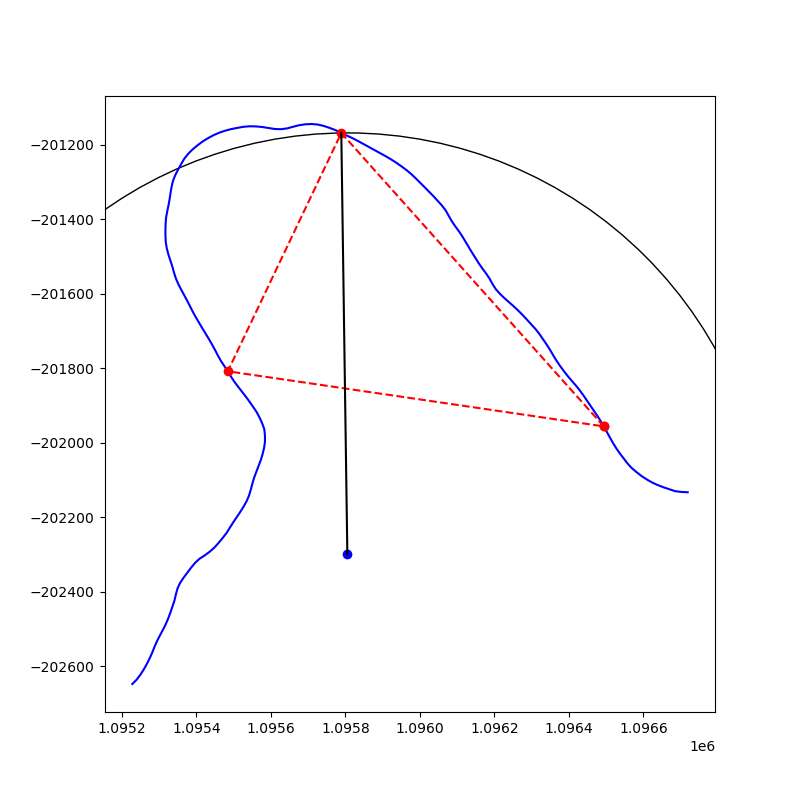

In [23]:
id_meander = 0
f = river.meanders[id_meander].plot_meander()


The selected meanders are saved as `Meander` objects inside a dictionary within the `River` class. The general information of the meanders is also saved in the `database` attribute as a dataframe.

In [23]:
# Display current database
database = river.database
database

,id_reach,huc04_n,huc_n,start_comid,comid,scale,x_st,y_st,translate,id_meander,...,l,l_inf,sinuosity,sinuosity_inf,so,skewness,flatness,radius,s_inf,curvature_side
id,,,,,,,,,,,,,,,,,,,,,
cf31c939-41fc-11ee-8b25-ec2e98e4452c_0,cf31c939-41fc-11ee-8b25-ec2e98e4452c,5000300006830.0,4,5.000300e+12,5.000300e+12,1,1.987417e+06,1.027346e+06,False,0,...,331.517183,329.590982,4.210193,3.141167,5.0,NaN,NaN,285.687679,"[74568.94850863895, 75602.99763289645]",1.0
cf31c939-41fc-11ee-8b25-ec2e98e4452c_1,cf31c939-41fc-11ee-8b25-ec2e98e4452c,5000300006830.0,4,5.000300e+12,5.000300e+12,1,1.987417e+06,1.027346e+06,False,1,...,517.764233,436.883762,2.323047,2.016469,5.0,NaN,NaN,222.959566,"[75177.2229204088, 76046.51830636973]",-1.0
cf31c939-41fc-11ee-8b25-ec2e98e4452c_2,cf31c939-41fc-11ee-8b25-ec2e98e4452c,5000300006830.0,4,5.000300e+12,5.000300e+12,1,1.987417e+06,1.027346e+06,False,2,...,149.480518,67.602107,2.644730,2.612334,5.0,NaN,NaN,43.773460,"[61964.84544175099, 62159.90579835796]",-1.0
cf31c939-41fc-11ee-8b25-ec2e98e4452c_3,cf31c939-41fc-11ee-8b25-ec2e98e4452c,5000300006830.0,4,5.000300e+12,5.000300e+12,1,1.987417e+06,1.027346e+06,False,3,...,283.730455,212.304755,2.428159,1.888118,5.0,NaN,NaN,109.021836,"[59149.055501728544, 59557.795717658984]",-1.0


#### Remove a meander

To remove a meander we can use `remove_meander(meander_id)` method in the `River` class. This method will remove the meander with the given `meander_id` from the river. You would also need to rerun the `interactive_meander_characterization_plot` method to update the meanders displayed.

In [16]:
# Remove meander
river.remove_meander(1)

#### Save information

To save the information you can use the method `save_meander_database`. This method will allow you to save the information as tables or as shapefile. Keep in mind that the meanders can be in both directions, thus saving the meander as shapefile will save two files, one file per direction.



In [24]:
# Save meander information in CSV format
river.save_meanders_database(
    path_output=path_meander_info, file_name='meander_database.csv',
    database='meander', type_info='csv')

river.save_meanders_database(
    path_output=path_meander_info, file_name='meander_database.feather',
    database='meander', type_info='feather')

# Save meander information in shapefile format
river.save_meanders_database(
    path_output=f'{path_meander_info}/shapefiles/', file_name='meander_database.shp',
    database='meander', type_info='shapefile', geometry_columns=['x_o', 'y_o'],
    crs='esri:102003')

                             

/Users/gonzad3/Documents/myRepos/pyMeanders/pyMeander/utilities/filesManagement.py:126: UserWarning:

Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.

/Users/gonzad3/Documents/myRepos/pyMeanders/pyMeander/utilities/filesManagement.py:126: UserWarning:

Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.

/Users/gonzad3/opt/anaconda3/envs/geopandas_env10/lib/python3.10/site-packages/geopandas/io/file.py:545: UserWarning:

You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.



#### Save and Load rivers

You can save the your entire work in files that could be later loaded by `Rivers` using the `Rivers.save_rivers` method. If you use the `.hdf5` extension on the file you will save all the rivers as `hdf5` files and the meander database as `csv`

In [25]:
# Save rivers
path_project = f'{path_output}/meander_manual_selection/'
rivers.save_rivers(
    path_project, file_name='rivers.hdf5',
    fn_meander_database='meander_database.csv')


2023-12-16 16:39:38,802[INFO] info: Saving 25000300004620.0
2023-12-16 16:39:38,805[INFO] info: 25000300004620.0 No CWT poly or ZC lines extracted
2023-12-16 16:39:38,806[INFO] info: 25000300004620.0 No tree scales extracted
2023-12-16 16:39:38,807[INFO] info: Saving 25000300004620.0
2023-12-16 16:39:38,809[INFO] info: 25000300004620.0 No CWT poly or ZC lines extracted
2023-12-16 16:39:38,810[INFO] info: 25000300004620.0 No tree scales extracted
2023-12-16 16:39:38,811[INFO] info: Saving 25000300015040.0
2023-12-16 16:39:38,812[INFO] info: 25000300015040.0 No CWT poly or ZC lines extracted
2023-12-16 16:39:38,813[INFO] info: 25000300015040.0 No tree scales extracted
2023-12-16 16:39:38,814[INFO] info: 25000300015040.0 No meanders extracted to save
2023-12-16 16:39:38,815[INFO] info: Saving 25000300015040.0
2023-12-16 16:39:38,816[INFO] info: 25000300015040.0 No CWT poly or ZC lines extracted
2023-12-16 16:39:38,818[INFO] info: 25000300015040.0 No tree scales extracted
2023-12-16 16:39:

In [5]:
# Start Rivers object
path_project = f'{path_output}/meander_manual_selection/'
rivers = Rivers(logger=logger)
river_network_file = f'{path_project}/rivers.hdf5'
rivers.load_river_network(
    river_network_file,
    # fn_meanders_database=f'{path_project}/meander_database.csv'
    )
id_rivers = rivers.id_values

# Select River
id_river = id_rivers[2]
river = rivers[id_river]

# kwargs resample
kwargs_resample = {
    id_river:{'smooth': 1e1},
}

# Re-load river
rivers.load_river_network(river_network_file, kwargs_resample=kwargs_resample)
id_rivers = rivers.id_values

# Select River
id_river = id_rivers[2]
river = rivers[id_river]

2024-01-30 10:10:03,517[INFO] info: Start Logger in RiverDatasets


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = './NHDPlus_HR/processed_data/NHDPlus_H_0602_HU4_GDB//meander_manual_selection//rivers.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [55]:
rivers[id_river].interactive_meander_characterization_plot()


FigureWidget({
    'data': [{'line': {'color': 'blue', 'width': 2},
              'mode': 'lines',
              'name': 'River',
              'type': 'scatter',
              'uid': '7e8dbf17-80f6-4952-bfb9-1884d710eeaa',
              'x': array([1934059.26224843, 1934104.17131248, 1934150.2829003 , ...,
                          2063968.01570591, 2064008.4960604 , 2064048.97839471]),
              'y': array([1116154.89691333, 1116141.62222088, 1116136.133648  , ...,
                          1011173.22794466, 1011196.11499387, 1011219.00134204])},
             {'hovertemplate': ('<b>Meander ID: 0</b><br>Lambda' ... 'nuosity: 1.63<br>Radius: 74.90'),
              'marker': {'color': 'red', 'size': 10},
              'mode': 'markers',
              'name': 'Meander 0',
              'showlegend': False,
              'type': 'scatter',
              'uid': '4902c791-58f2-4151-864d-447c95db7391',
              'x': [1945906.569615304],
              'y': [1083673.7749246547]},
    

## Automatic Detection

We can performed automatic detection on the same reaches. All of the automatically detected rivers will be saved in the database with the `automaic_flag` as 1. To perform the automatic detection please follow the steps below:

In [13]:
# Directories of the information
path_tables = f'{path_output}/tables/'
path_coords = f'{path_output}/coordinates/'

# Create Rivers object
rivers = Rivers(logger=logger)
# Add  files
rivers.add_files(path_data=path_tables, huc04=huc_id, path_coords=path_coords,
                comid_id='nhdplusid', load_coords=True)
# Load Linking Files
linking_network_file = f'{path_river_routing}/linking_network.feather'
comid_network_file = f'{path_river_routing}/comid_network.hdf5'
rivers.load_linking_network(linking_network_file)

# Load HUC files extracted
huc_list = rivers.load_huc_list_in_comid_network(comid_network_file)
huc = huc_list[0]
headwaters = rivers.load_extracted_in_comid_network(
    comid_network_file, huc=huc)
headwaters = headwaters[huc]

# Load headwaters
river_network_file = f'{path_river_routing}/river_network_huc_{huc}.hdf5'
# headwaters = rivers.load_river_network_ids(river_network_file)

# kwargs resample
kwargs_resample = {hw: {'smooth': 1e1} for hw in headwaters}

rivers.load_river_network(river_network_file, headwaters_comid=headwaters,
                          kwargs_resample=kwargs_resample)
id_rivers = rivers.id_values
print(id_rivers)

['24001400009880', '24001400057528', '24001400080454', '24001400054242', '24001400016302', '24001400023658', '24001400014334', '24001400019630', '24001400021867', '24001400069273', '24001400034467', '24001400010117', '24001400066617', '24001400041022', '24001400019829', '24001400036809', '24001400003085', '24001400027136', '24001400054752', '24001400012196', '24001400058343', '24001400074165', '24001400065735', '24001400082072', '24001400013713', '24001400007208', '24001400005805', '24001400022336', '24001400069865', '24001400073611', '24001400069266', '24001400054661', '24001400027027', '24001400017483', '24001400079103', '24001400039457', '24001400032091', '24001400064752', '24001400016983', '24001400020880', '24001400061725', '24001400013796', '24001400067573', '24001400047161', '24001400000019', '24001400056048', '24001400027046', '24001400047333', '24001400039045', '24001400062987', '24001400044264', '24001400026742', '24001400042668', '24001400063268', '24001400047960', '24001400

In [11]:
id_rivers = rivers.id_values
print(len(id_rivers))

30811


### Multiscale Analysis of Rivers

In [7]:
for river_id in id_rivers:
    # Calculate curvature
    rivers[f'{river_id}'].calculate_curvature()
    # Calculate CWT
    rivers[f'{river_id}'].get_cwt_curvature(mother='MORLET')
    rivers[f'{river_id}'].get_cwt_angle(mother='MORLET')

In [8]:
plt.close('all')
utl.cr_folder('results/')
for river_id in id_rivers:
    graphs.plot_river_spectrum_compiled(rivers[f'{river_id}'],
                                        only_significant=True)
    plt.savefig(f'results/{river_id}.png', format='png', dpi=300)
    plt.close('all')

### Process to perform automatic detection

The process to perform the automatic detection from a created rivers object involves the following steps:

1. **Calculate curvature**: Use the function `rivers[id_river].calculate_curvature()` to estimate the curvature of the river transect.

In [81]:
# -----------------------------
# Information
# -----------------------------
path_tables = f'{path_output}/tables/'
path_coords = f'{path_output}/coordinates/'
# -----------------------------
# Create Rivers object
# -----------------------------
rivers = Rivers(logger=logger)
# -----------------------------
# Add files
# -----------------------------
rivers.add_files(path_data=path_tables, huc04=huc_id, path_coords=path_coords,
                comid_id='nhdplusid', load_coords=False)
# -----------------------------
# load Linking Files
# -----------------------------
linking_network_file = f'{path_river_routing}/linking_network.feather'
comid_network_file = f'{path_river_routing}/comid_network.hdf5'
rivers.load_linking_network(linking_network_file)
# -----------------------------
# load HUC files extracted
# -----------------------------
huc_list = rivers.load_huc_list_in_comid_network(comid_network_file)
huc = huc_list[0]
headwaters = rivers.load_extracted_in_comid_network(
    comid_network_file, huc=huc)
headwaters = headwaters[huc]

# ====================================
# Iterate over series river transects
# ====================================
initial_step = 100
step = 2000
full_dataset = len(headwaters)
initial_range = np.array([0, initial_step])
range_values = np.arange(initial_range[-1], full_dataset, step)
# range_values = np.append(initial_range, range_values[1:])
if range_values[-1] < full_dataset:
    range_values = np.append(range_values, full_dataset)
elif range_values[-1] > full_dataset:
    range_values[-1] = full_dataset

print(len(range_values))
# TODO: This is a good example of within waterbody!
# range = [1007, 1008]
for r_val, i in enumerate(range_values[:-1]):
    # Select range
    range = [range_values[r_val], range_values[r_val + 1]]
    # -----------------------------
    # Create Rivers object
    # -----------------------------
    rivers = Rivers(logger=logger)
    # -----------------------------
    # Add files
    # -----------------------------
    rivers.add_files(path_data=path_tables, huc04=huc_id, path_coords=path_coords,
                    comid_id='nhdplusid', load_coords=False)
    # -----------------------------
    # load Linking Files
    # -----------------------------
    linking_network_file = f'{path_river_routing}/linking_network.feather'
    comid_network_file = f'{path_river_routing}/comid_network.hdf5'
    rivers.load_linking_network(linking_network_file)
    # -----------------------------
    # load HUC files extracted
    # -----------------------------
    huc_list = rivers.load_huc_list_in_comid_network(comid_network_file)
    huc = huc_list[0]
    headwaters = rivers.load_extracted_in_comid_network(
        comid_network_file, huc=huc)
    headwaters = headwaters[huc]
    # -----------------------------
    # Select River
    # -----------------------------
    headwaters = headwaters[range[0]: range[1]]
    # -----------------------------
    # Load headwaters
    # -----------------------------
    river_network_file = f'{path_river_routing}/river_network_huc_{huc}.hdf5'
    kwargs_resample = {hw: {'smooth': 1e1, 'method': 'geometric_mean_width'} for hw in headwaters}
    rivers.load_river_network(river_network_file, headwaters_comid=headwaters,
                            kwargs_resample=kwargs_resample)
    id_rivers = rivers.id_values
    print(f'Rivers to process: {len(id_rivers)}')
    if len(id_rivers) == 0:
        continue

    id_rivers_extracted = id_rivers
    time1 = time.time()
    for i_val, id_river in enumerate(id_rivers):
        if i_val % 500 == 0:
            print(f'Processing River {i_val} of {len(id_rivers)}')
        river = rivers[id_river]
        # -----------------------------
        # Calculate Curvature
        # -----------------------------
        rivers[id_river].calculate_curvature(data_source='resample') 
        # -----------------------------
        # Extract CWT tree
        # -----------------------------
        rivers[id_river].extract_cwt_tree()
        # -----------------------------
        # Prune by peak power
        # -----------------------------
        rivers[id_river].prune_tree_by_peak_power()
        # -----------------------------
        # Prune by sinuosit
        # -----------------------------
        rivers[id_river].prune_tree_by_sinuosity(1.01)
        # -----------------------------
        # Add meander to database
        # -----------------------------
        rivers[id_river].add_meanders_from_tree_scales(
            bounds_array_str='extended')
        # ---------------------------
        # Calculate reach sinuosity
        # ---------------------------
        rivers[id_river].calculate_reach_metrics()
    utl.toc(time1)

    # Save rivers
    print('Saving Information')
    if range[1] - range[0] > 1:
        path_output_meanders = f'{path_meander_info}/{range[0]}_{range[1]-1}/'
    else:
        path_output_meanders = f'{path_meander_info}/{range[0]}/'
    rivers.save_databases_meanders(
        path_output_meanders, f'meander_database.csv')
    rivers.save_rivers(
        path_output_meanders, file_name=f'rivers.hdf5',
        fn_meander_database='meander_database.feather',
        save_cwt_info=False, rivers_ids=id_rivers_extracted)


17
Rivers to process: 2000
Processing River 0 of 2000
Processing River 500 of 2000
Processing River 1000 of 2000


: 

<Axes: >

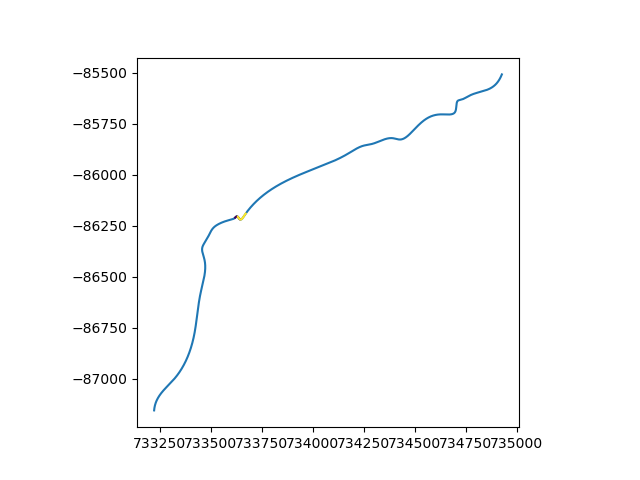

In [65]:
id_river = id_rivers[-1]
comid_network = rivers.reach_generator.comid_network['0513'][id_river]
linking_network = rivers.reach_generator.linking_network.loc[comid_network, 'within_waterbody']
tree_scales = rivers[id_river].tree_scales_database
comid_c = tree_scales['comid_c']
waterbody_tree = tree_scales['within_waterbody']
river = rivers[id_river]
x = rivers[id_river].x
y = rivers[id_river].y
f, ax = plt.subplots(1, 1)
ax.plot(x, y)
gdf = rivers[id_river].create_meander_geopandas_dataframe(geometry_columns=['x', 'y'])
gdf.plot(ax=ax, column='curvature_side')

In [ ]:
import dotenv
print(id_rivers)
id_river = id_rivers[-1]
satellite_figure = True
dotenv.load_dotenv()
MAPBOX_TOKEN = os.environ['MAPBOX_TOKEN']
rivers[id_river].interactive_meander_characterization_plot(
    mapbox_token=MAPBOX_TOKEN, current_crs='esri:102003', zoom=7)

In [1]:
# Plot tree
rivers[id_river].plot_tree_nodes(markersize=2, linewidth=0.5)


NameError: name 'rivers' is not defined